In [1]:
from datasets import load_dataset_builder
from datasets import load_dataset, get_dataset_split_names
import numpy as np

*Pour ce TP, nous allons travailler sur une tâche de classification multi-classes. Nous utilisons la partie "classification des émotions" du jeu de données "tweet-eval" qui contient des tweets appartenant à l'une des quatre classes suivantes : colère, joie, optimisme et tristesse. Pour plus de détails sur l'ensemble de données, consultez le site https://huggingface.co/datasets/tweet_eval.

La liste des autres ensembles de données disponibles est disponible sur https://huggingface.co/datasets.

In [2]:
twitter_dataset = load_dataset_builder("tweet_eval", 'emotion')

In [3]:
twitter_dataset.info.description

''

In [4]:
twitter_dataset.info.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['anger', 'joy', 'optimism', 'sadness'], id=None)}

In [5]:
get_dataset_split_names("tweet_eval", 'emotion')

['train', 'test', 'validation']

In [6]:
global_train_dataset = load_dataset("tweet_eval", 'emotion', split='train')
global_validation_dataset = load_dataset("tweet_eval", 'emotion', split='validation')
global_test_dataset = load_dataset("tweet_eval", 'emotion', split='test')

## **SVM bag of words model**

Nous commençons par entraîner un modèle simple basé sur un SVM. CountVectorizer est utilisé pour encoder les tweets d'entrée en représentations vectorielles. Reportez-vous à https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html pour plus de détails sur le modèle.

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noahberneaud/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/noahberneaud/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/noahberneaud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/noahberneaud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/noahberneaud/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/noahberneaud/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [8]:
import re
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import spacy
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Global varaibles and declarations
stopwords_english = stopwords.words('english')
word_lemmatizer = WordNetLemmatizer()
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

In [9]:
# utility functions for text preprocessing
def preprocess_text(text):
    '''This function applies different preprocessing methods to the input text including removing stop words,
    removing special characters and lematization'''
    
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [re.sub(r'[^a-zA-Z0-9]', '', t) for t in tokens]
    tokens = [t for t in tokens if t not in stopwords_english and len(t)>0]
    tokens = pos_tag(tokens)
    final_tokens = []
    for w, t in tokens:
        final_word = word_lemmatizer.lemmatize(w, tag_map[t])
        final_tokens.append(final_word)
    final_text = " ".join(final_tokens)
    return final_text
preprocess_text("This is a sample expression for testing the preprocessing funcions")

'sample expression testing preprocessing funcions'

### Data preparation for training

Comme le jeu de données HuggingFace n'est pas directement compatible avec sklearn, nous transformons les données dans une forme compatible avec le modèle SVM.

In [10]:
svm_train, svm_train_labels = [], []
svm_dev, svm_dev_labels = [], []
svm_test, svm_test_labels = [], []

for i in range(len(global_train_dataset['text'])):
    svm_train.append(global_train_dataset['text'][i])
    svm_train_labels.append(global_train_dataset['label'][i])

for i in range(len(global_validation_dataset['text'])):
    svm_dev.append(global_validation_dataset['text'][i])
    svm_dev_labels.append(global_validation_dataset['label'][i])

for i in range(len(global_test_dataset['text'])):
    svm_test.append(global_test_dataset['text'][i])
    svm_test_labels.append(global_test_dataset['label'][i])

len(svm_train), len(svm_train_labels), len(svm_dev), len(svm_dev_labels), len(svm_test), len(svm_test_labels)

(3257, 3257, 374, 374, 1421, 1421)

Encodage du texte d'entrée pour obtenir des représentations vectorielles. Nous utilisons CountVectorizer à cette fin. D'autres méthodes d'encodage peuvent également être utilisées. La documentation de CountVectorizer se trouve ici : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
train_features = np.asarray(vectorizer.fit_transform(svm_train).todense())
train_labels = np.array(svm_train_labels)
dev_features, test_features = np.asarray(vectorizer.transform(svm_dev).todense()), np.asarray(vectorizer.transform(svm_test).todense())
dev_labels, test_labels = np.array(svm_dev_labels), np.array(svm_test_labels)
type(train_features), train_features.shape

(numpy.ndarray, (3257, 8328))

Formation du modèle SVC avec un noyau polynomial de degré 5.

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


clf = make_pipeline(SVC(kernel='poly', degree=5, class_weight="balanced"))
clf.fit(train_features, train_labels)
train_pred = clf.predict(train_features)
dev_pred = clf.predict(dev_features)
print(f"Training accuracy: {accuracy_score(train_labels, train_pred)},\t Validation accuracy: {accuracy_score(dev_labels, dev_pred)}")

Training accuracy: 0.7995087503837888,	 Validation accuracy: 0.3155080213903743


#### Question 1 : Indiquez d'autres paramètres d'évaluation tels que fscore, precision, recall.

In [13]:
import sklearn
print(f"fscore: {sklearn.metrics.f1_score(dev_labels, dev_pred, average='macro')},\t precision: {sklearn.metrics.precision_score(dev_labels, dev_pred, average='macro')},\t recall: {sklearn.metrics.recall_score(dev_labels, dev_pred, average='macro')}")

fscore: 0.19434223243175103,	 precision: 0.3769350282485876,	 recall: 0.2672703941271864


/Users/noahberneaud/Documents/portfolio/M1_Informatique/TAL/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Question 2 : Indiquez la performance sur l'ensemble de test pour le modèle le plus performant sur l'ensemble d'essai.

In [14]:
test_pred = clf.predict(test_features)
print(f"Test accuracy: {accuracy_score(test_labels, test_pred)}")


Test accuracy: 0.3124560168895144


#### Question 3 : Entraînez des modèles avec différents paramètres de noyau et indiquez les meilleurs résultats.

In [ ]:
import sklearn.svm as svm
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf','poly'), 'C':[1, 10], 'degree':[3, 5, 7]}
clf = GridSearchCV(svm.SVC(), parameters)
clf.fit(train_features, train_labels)
train_pred = clf.predict(train_features)
dev_pred = clf.predict(dev_features)
print(clf.best_params_)


# BiLSTM based **models**

Formation de modèles profonds basés sur les LSTM pour la classification multiclasse. Nous utilisons des encastrements de mots GloVe pré-entraînés pour encoder le texte d'entrée.

Liens de référence :
https://nlp.stanford.edu/projects/glove/

In [16]:
import torch
from nltk.tokenize import word_tokenize
import numpy as np
import re
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn
from torch.utils.data import DataLoader

#### Data preparation

In [17]:
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [re.sub(r'[^a-zA-Z0-9]', '', t) for t in tokens]
    final_tokens = tokens
    final_text = " ".join(final_tokens)
    return final_text

def upload_glove():
    word2idx = {}
    word_list = []
    embeddings = []
    embeddings.append(np.zeros(50))
    with open("./glove.6B.50d.txt", "r", encoding="UTF8") as file:
        lines = file.readlines()
    for i, l in enumerate(lines):
        temp_list = l.split(" ")
        word_list.append(temp_list[0])
        vector = np.asarray(temp_list[1:], dtype=np.double)
        embeddings.append(vector)
        word2idx[temp_list[0]] = i+1
    embeddings = torch.as_tensor(np.asarray(embeddings), dtype=torch.float)
    return embeddings, word2idx, word_list
glove_embeddings, word2idx, word_list = upload_glove()

glove_embeddings : tenseur de forme (num_words X embed_dim). Il contient des exmbeddings pré-entraînés pour tous les mots disponibles.

word2idx : dict établissant une correspondance entre les mots et leur position idx

word_list : liste de mots avec les encodages disponibles

In [18]:
glove_embeddings.shape, type(word2idx), type(word_list)

(torch.Size([400001, 50]), dict, list)

### Définition d'un jeu de données personnalisé

Code permettant de définir un jeu de données personnalisé et des classes de chargement de données pour le modèle d'apprentissage. Des plateformes comme huggingface et pytorch contiennent des ensembles de données au format standard qui peuvent être directement utilisés pour l'apprentissage. Cependant, il est parfois nécessaire de définir des classes de jeux de données personnalisées pour obtenir le comportement souhaité.

Pour plus d'informations sur les ensembles de données existants et la création d'ensembles de données personnalisés dans pytorch, consultez le site https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files.

In [19]:
from torch.utils.data import Dataset
from collections import namedtuple
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, text_list, label):
        super(CustomDataset, self).__init__()
        self.text = text_list
        self.tokens = []
        self.encodings = self.process_data()
        self.labels = label
    
    def process_data(self):
        encodings = []
        
        for i in tqdm(range(len(self.text))):
            current_text = self.text[i]
            current_text = preprocess_text(current_text)
            tokens = [t for t in current_text.split(" ") if len(t)>0]
            self.tokens.append(tokens)
            idx_list = []
            for w in tokens:
                if w in word_list:
                    idx_list.append(word2idx[w])
                else:
                    idx_list.append(int(0))
#             print(idx_list)
            encodings.append(idx_list)
        return encodings
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        data_tuple = namedtuple("data_input", "features tokens text y")
        d = data_tuple(
            features=torch.as_tensor(self.encodings[idx]),
            tokens=self.tokens[idx],
            text=self.text[idx],
            y=torch.as_tensor(self.labels[idx])
        )
        return d

print("Encoding training data.")
train_dataset = CustomDataset(global_train_dataset['text'], global_train_dataset['label'])
print("Encoding validation data.")
dev_dataset = CustomDataset(global_validation_dataset['text'], global_validation_dataset['label'])
print("Encoding test data.")
test_dataset = CustomDataset(global_test_dataset['text'], global_test_dataset['label'])

Encoding training data.


100%|██████████| 3257/3257 [00:06<00:00, 500.87it/s]


Encoding validation data.


100%|██████████| 374/374 [00:00<00:00, 473.19it/s]


Encoding test data.


100%|██████████| 1421/1421 [00:02<00:00, 481.52it/s]


In [20]:
def collate_func(batch):
    features = torch.nn.utils.rnn.pad_sequence([b.features for b in batch], batch_first=True, padding_value=0)
    target = torch.stack([b.y for b in batch])
    return features, target

train_dataloader = DataLoader(train_dataset, batch_size=256, collate_fn=collate_func, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=256, collate_fn=collate_func, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, collate_fn=collate_func, shuffle=True)

#### Model definition

Links for different layers used:

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html

https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

In [21]:
import torch.nn.functional as F

class Model(torch.nn.Module):
    def __init__(self, device, glove_embeddings):
        super(Model, self).__init__()
        self.device = device
        self.dropout_prob = 0.2
        
        self.embedding = torch.nn.Embedding.from_pretrained(glove_embeddings)
        self.lstm = torch.nn.LSTM(50, 50, 1, bidirectional=False, dropout=self.dropout_prob)
        self.attention = torch.nn.MultiheadAttention(50, 1, batch_first=True)
        self.ff_1 = torch.nn.Linear(50, 50)
        self.ff_2 = torch.nn.Linear(50, 32)
        self.ff_3 = torch.nn.Linear(32, 4)
        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, batch):
        features = batch[0].type(torch.LongTensor).to(self.device)
        
        features = self.embedding(features)
        features = features.type(torch.FloatTensor)
        output, (h, c) = self.lstm(features)
        output, attention_scores = self.attention(output, output, output, need_weights=True, average_attn_weights=False)
        output = torch.mean(output, dim=1, keepdim=False)
        output = F.dropout(F.leaky_relu(output), p=self.dropout_prob, training=self.training)
        output = self.ff_1(output)
        output = F.dropout(F.leaky_relu(output), p=self.dropout_prob, training=self.training)
        output = self.ff_2(output)
        output = F.dropout(F.leaky_relu(output), p=self.dropout_prob, training=self.training)
        output = self.ff_3(output)
        output = self.softmax(output)
        return output, attention_scores

device = torch.device("cpu")
model = Model(device, glove_embeddings)
model.to(device)

/Users/noahberneaud/Documents/portfolio/M1_Informatique/TAL/.venv/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Model(
  (embedding): Embedding(400001, 50)
  (lstm): LSTM(50, 50, dropout=0.2)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
  )
  (ff_1): Linear(in_features=50, out_features=50, bias=True)
  (ff_2): Linear(in_features=50, out_features=32, bias=True)
  (ff_3): Linear(in_features=32, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

Différentes plates-formes sont disponibles pour le suivi des informations pendant l'apprentissage du modèle.
Nous montrons l'utilisation de tensorboard. D'autres services en ligne comme Comet.ml peuvent également être utilisés à des fins de suivi.

Pytorch se connecte à tensorboard en utilisant le module SummaryWriter https://pytorch.org/docs/stable/tensorboard.html

In [22]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score

writer = SummaryWriter(log_dir="./logs/")

classification_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 50
step = 0

# Training loop
for e in range(num_epochs):
    model.train()
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad(set_to_none=True)
        targets = batch[1].to(device)
        prediction, attention_scores = model(batch)
        loss = classification_loss(prediction, targets)
        loss.backward()
        optimizer.step()
        prediction = prediction.cpu().detach().numpy()
        prediction = np.argmax(prediction, axis=1)
        loss = loss.detach().cpu().item()
        targets = targets.detach().cpu().numpy()
        accuracy = accuracy_score(targets, prediction)
        writer.add_scalar('Loss/Train', loss, step)
        writer.add_scalar('Accuracy/Train', accuracy, step)
        step += 1

    model.eval()
    for i, batch in enumerate(dev_dataloader):
        targets = batch[1].to(device)
        prediction, attention_scores = model(batch)
        loss = classification_loss(prediction, targets)
        prediction = prediction.cpu().detach().numpy()
        prediction = np.argmax(prediction, axis=1)
        loss = loss.detach().cpu().item()
        targets = targets.detach().cpu().numpy()
        accuracy = accuracy_score(targets, prediction)
        writer.add_scalar('Loss/Dev', loss, step)
        writer.add_scalar('Accuracy/Dev', accuracy, step)

    for i, batch in enumerate(test_dataloader):
        targets = batch[1].to(device)
        prediction, attention_scores = model(batch)
        loss = classification_loss(prediction, targets)
        prediction = prediction.cpu().detach().numpy()
        prediction = np.argmax(prediction, axis=1)
        loss = loss.detach().cpu().item()
        targets = targets.detach().cpu().numpy()
        accuracy = accuracy_score(targets, prediction)
        writer.add_scalar('Loss/Test', loss, step)
        writer.add_scalar('Accuracy/Test', accuracy, step)
step

650

Le paquet Bertviz permet de visualiser facilement l'attention au sein de la couche MultiHeadAttention du modèle. 

In [ ]:
from bertviz import model_view

tokens = train_dataset[0].tokens
prediction, attention = model([torch.unsqueeze(train_dataset[0].features, dim=0)])
model_view(torch.unsqueeze(attention, dim=0), tokens)

In [24]:
train_dataset[0].text

"“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry"

#### Tensorboard peut être lancé en exécutant la commande suivante dans le terminal

tensorboard --logdir=logs/

## Exercice : 

Entraînez un modèle basé sur l'apprentissage profond pour l'ensemble de données GO Emotions pour la classification des émotions multi-label. https://huggingface.co/datasets/go_emotions

Comparez les performances des modèles utilisant LSTM, BiLASTM, GRU, BiGRU et seulement des couches d'attention.

Rédigez un petit rapport expliquant les étapes du traitement des données, les définitions du modèle et l'analyse des résultats.

Les soumissions doivent être terminées avant le 9 mai.

In [25]:
import torch.nn.functional as F

class LSTM(torch.nn.Module):
    def __init__(self, device, glove_embeddings,name):
        super(LSTM, self).__init__()
        self.device = device
        self.dropout_prob = 0.2
        self.name = name
        self.embedding = torch.nn.Embedding.from_pretrained(glove_embeddings)
        self.modele = torch.nn.LSTM(50, 50, 2, bidirectional=False, dropout=self.dropout_prob)
        self.attention = torch.nn.MultiheadAttention(50, 2, batch_first=True,dropout = self.dropout_prob)
        self.ff_1 = torch.nn.Linear(50, 4)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, batch):
        features = batch[0].type(torch.LongTensor).to(self.device)
        features = self.embedding(features)
        features = features.type(torch.cuda.FloatTensor)
        output, (h, c) = self.modele(features)
        output, attention_scores = self.attention(output, output, output, need_weights=True, average_attn_weights=False)
        output = torch.mean(output, dim=1, keepdim=False)
        output = F.dropout(F.leaky_relu(output), p=self.dropout_prob, training=self.training)
        output = self.ff_1(output)
        output = self.softmax(output)
        return output, attention_scores

In [26]:
class BiGRU(torch.nn.Module):
    def __init__(self, device, glove_embeddings,name):
        super(BiGRU, self).__init__()
        self.device = device
        self.dropout_prob = 0.2
        self.name = name

        self.embedding = torch.nn.Embedding.from_pretrained(glove_embeddings)
        self.modele = torch.nn.GRU(50, 50, 2, bidirectional=True, dropout=self.dropout_prob)
        self.attention = torch.nn.MultiheadAttention(100, 4, batch_first=True)
        self.ff_1 = torch.nn.Linear(100, 4)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, batch):
        features = batch[0].type(torch.LongTensor).to(self.device)

        features = self.embedding(features)
        features = features.type(torch.cuda.FloatTensor)
        output, _ = self.modele(features)
        output, _ = self.attention(output, output, output, need_weights=True, average_attn_weights=False)
        output = torch.mean(output, dim=1, keepdim=False)
        output = F.dropout(F.leaky_relu(output), p=self.dropout_prob, training=self.training)
        output = self.ff_1(output)
        output = F.dropout(F.leaky_relu(output), p=self.dropout_prob, training=self.training)
        output = self.softmax(output)
        return output, attention_scores

In [27]:
class GRU(torch.nn.Module):
    def __init__(self, device, glove_embeddings,name):
        super(GRU, self).__init__()
        self.device = device
        self.dropout_prob = 0.2
        self.name = name
        self.embedding = torch.nn.Embedding.from_pretrained(glove_embeddings)
        self.modele = torch.nn.GRU(50, 50, 2, bidirectional=False, dropout=self.dropout_prob)
        self.modele2 = torch.nn.GRU(50, 50, 2, bidirectional=False, dropout=self.dropout_prob)
        self.attention = torch.nn.MultiheadAttention(50, 2, batch_first=True)
        self.ff_1 = torch.nn.Linear(50,4)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, batch):
        features = batch[0].type(torch.LongTensor).to(self.device)

        features = self.embedding(features)
        features = features.type(torch.cuda.FloatTensor)
        output, _ = self.modele(features)
        output, attention_scores = self.attention(output, output, output, need_weights=True, average_attn_weights=False)
        output, _ = self.modele2(output)
        output, attention_scores = self.attention(output, output, output, need_weights=True, average_attn_weights=False)
        output = torch.mean(output, dim=1, keepdim=False)
        output = F.dropout(F.leaky_relu(output), p=self.dropout_prob, training=self.training)
        output = self.softmax(output)
        return output, attention_scores

In [ ]:
import torch.nn.functional as F

class BiLSTM(torch.nn.Module):
    def __init__(self, device, glove_embeddings,name):
        super(BiLSTM, self).__init__()
        self.device = device
        self.dropout_prob = 0.2
        self.name = name

        self.embedding = torch.nn.Embedding.from_pretrained(glove_embeddings)
        self.modele = torch.nn.LSTM(50, 50, 2, bidirectional=True, dropout=self.dropout_prob)
        self.attention = torch.nn.MultiheadAttention(100, 4, batch_first=True)
        self.ff_1 = torch.nn.Linear(100, 4)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, batch):
        features = batch[0].type(torch.LongTensor).to(self.device)

        features = self.embedding(features)
        features = features.type(torch.cuda.FloatTensor)
        output, (h, c) = self.modele(features)
        output, _ = self.attention(output, output, output, need_weights=True, average_attn_weights=False)
        output = torch.mean(output, dim=1, keepdim=False)
        output = F.dropout(F.leaky_relu(output), p=self.dropout_prob, training=self.training)
        output = self.ff_1(output)
        output = self.softmax(output)
        return output, attention_scores

device = torch.device("cuda")
modelLSTM = LSTM(device, glove_embeddings,"LSTM")
modelLSTM.to(device)
modelBILSTM = BiLSTM(device, glove_embeddings,"BILSTM")
modelBILSTM.to(device)
modelGRU = GRU(device, glove_embeddings,"GRU")
modelGRU.to(device)
modelBIGRU = BiGRU(device, glove_embeddings,"BIGRU")
modelBIGRU.to(device)


In [ ]:
def collate_func(batch):
    features = torch.nn.utils.rnn.pad_sequence([b.features for b in batch], batch_first=True, padding_value=0)
    target = torch.stack([b.y for b in batch])
    return features, target

train_dataloader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_func, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=32, collate_fn=collate_func, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_func, shuffle=True)

In [ ]:
model = modelBILSTM

F1 macro test : 0.5317460317460317 avec le modele BILSTM
F1 micro test : 0.6923076923076923 avec le modele BILSTM
F1 macro val : 0.46885964912280703 avec le modele BILSTM
F1 micro val : 0.5909090909090909 avec le modele BILSTM


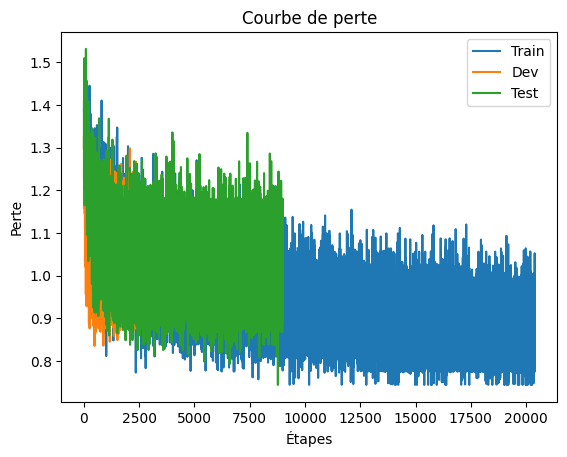

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

writer = SummaryWriter(log_dir="./logs/")


classification_loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=7e-4)
num_epochs = 100
step = 0

train_losses = []
dev_losses = []
test_losses = []

for e in range(200):
    model.train()
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad(set_to_none=True)
        targets = batch[1].to(device)
        prediction, attention_scores = model(batch)
        loss = classification_loss(prediction, targets)
        loss.backward()
        optimizer.step()
        prediction = prediction.cpu().detach().numpy()
        prediction = np.argmax(prediction, axis=1)
        loss = loss.detach().cpu().item()
        targets = targets.detach().cpu().numpy()
        accuracy = accuracy_score(targets, prediction)
        writer.add_scalar(model.name+' Loss/Train', loss, step)
        writer.add_scalar(model.name+' Accuracy/Train', accuracy, step)
        step += 1
        train_losses.append(loss)

    model.eval()
    for i, batch in enumerate(dev_dataloader):
        targets = batch[1].to(device)
        prediction, attention_scores = model(batch)
        loss = classification_loss(prediction, targets)
        prediction = prediction.cpu().detach().numpy()
        prediction = np.argmax(prediction, axis=1)
        loss = loss.detach().cpu().item()
        targets = targets.detach().cpu().numpy()
        accuracy = accuracy_score(targets, prediction)
        f1_macro_val = sklearn.metrics.f1_score(targets, prediction, average='macro')
        f1_micro_val = sklearn.metrics.f1_score(targets, prediction, average='micro')
        writer.add_scalar(model.name+' Loss/Dev', loss, step)
        writer.add_scalar(model.name+' Accuracy/Dev', accuracy, step)
        dev_losses.append(loss)

    for i, batch in enumerate(test_dataloader):
        targets = batch[1].to(device)
        prediction, attention_scores = model(batch)
        loss = classification_loss(prediction, targets)
        prediction = prediction.cpu().detach().numpy()
        prediction = np.argmax(prediction, axis=1)
        loss = loss.detach().cpu().item()
        targets = targets.detach().cpu().numpy()
        accuracy = accuracy_score(targets, prediction)
        f1_macro_test = sklearn.metrics.f1_score(targets, prediction, average='macro')
        f1_micro_test = sklearn.metrics.f1_score(targets, prediction, average='micro')
        writer.add_scalar(model.name+' Loss/Test', loss, step)
        writer.add_scalar(model.name+' Accuracy/Test', accuracy, step)
        test_losses.append(loss)

step
print(f"F1 macro test : {f1_macro_test} avec le modele " + model.name)
print(f"F1 micro test : {f1_micro_test} avec le modele " + model.name)
print(f"F1 macro val : {f1_macro_val} avec le modele " + model.name)
print(f"F1 micro val : {f1_micro_val} avec le modele " + model.name)

# Tracer la courbe de la perte
plt.plot(train_losses, label='Train')
plt.plot(dev_losses, label='Dev')
plt.plot(test_losses, label='Test')
plt.title('Courbe de perte')
plt.xlabel('Étapes')
plt.ylabel('Perte')
plt.legend()
plt.show()


In [ ]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score

writer = SummaryWriter(log_dir="./logs/")

classification_loss_LSTM = torch.nn.CrossEntropyLoss()
optimizer_LSTM = torch.optim.Adam(modelLSTM.parameters(), lr=1e-5)
scheduler_LSTM =torch.optim.lr_scheduler.StepLR(optimizer_LSTM, step_size=5, gamma=0.1)
classification_loss_BILSTM = torch.nn.CrossEntropyLoss()
scheduler_BILSTM = optimizer_BILSTM = torch.optim.Adam(modelBILSTM.parameters(), lr=1e-5)
torch.optim.lr_scheduler.StepLR(optimizer_BILSTM, step_size=5, gamma=0.1)
classification_loss_GRU = torch.nn.CrossEntropyLoss()
optimizer_GRU = torch.optim.Adam(modelGRU.parameters(), lr=1e-5)
scheduler_GRU =torch.optim.lr_scheduler.StepLR(optimizer_GRU, step_size=5, gamma=0.1)
classification_loss_BIGRU = torch.nn.CrossEntropyLoss()
optimizer_BIGRU = torch.optim.Adam(modelBIGRU.parameters(), lr=1e-5)
scheduler_BIGRU = torch.optim.lr_scheduler.StepLR(optimizer_BIGRU, step_size=5, gamma=0.1)
num_epochs = 100
step = 0

for model in [modelLSTM,modelBILSTM,modelGRU,modelBIGRU]:
    # Training loop
    if(model.name == "LSTM"):
            classification_loss = classification_loss_LSTM
            optimizer = optimizer_LSTM
            scheduler = scheduler_LSTM
            num_epochs = 20
    elif(model.name == "BILSTM"):
            classification_loss = classification_loss_BILSTM
            optimizer = optimizer_BILSTM
            scheduler = scheduler_BILSTM
            num_epochs = 100
    elif(model.name == "GRU"):
            classification_loss = classification_loss_GRU
            optimizer = optimizer_GRU
            scheduler = scheduler_GRU
            num_epochs = 20
    elif(model.name == "BIGRU"):
            classification_loss = classification_loss_BIGRU
            optimizer = optimizer_BIGRU
            scheduler = scheduler_BIGRU
            num_epochs = 100
    for e in range(num_epochs):
        model.train()
        for i, batch in enumerate(train_dataloader):
            optimizer.zero_grad(set_to_none=True)
            targets = batch[1].to(device)
            prediction, attention_scores = model(batch)
            loss = classification_loss(prediction, targets)
            loss.backward()
            optimizer.step()
            prediction = prediction.cpu().detach().numpy()
            prediction = np.argmax(prediction, axis=1)
            loss = loss.detach().cpu().item()
            targets = targets.detach().cpu().numpy()
            accuracy = accuracy_score(targets, prediction)
            writer.add_scalar(model.name+' Loss/Train', loss, step)
            writer.add_scalar(model.name+' Accuracy/Train', accuracy, step)
            step += 1
        scheduler.step()

        model.eval()
        for i, batch in enumerate(dev_dataloader):
            targets = batch[1].to(device)
            prediction, attention_scores = model(batch)
            loss = classification_loss(prediction, targets)
            prediction = prediction.cpu().detach().numpy()
            prediction = np.argmax(prediction, axis=1)
            loss = loss.detach().cpu().item()
            targets = targets.detach().cpu().numpy()
            accuracy = accuracy_score(targets, prediction)
            f1_macro_val = sklearn.metrics.f1_score(targets, prediction, average='macro')
            f1_micro_val = sklearn.metrics.f1_score(targets, prediction, average='micro')
            writer.add_scalar(model.name+' Loss/Dev', loss, step)
            writer.add_scalar(model.name+' Accuracy/Dev', accuracy, step)

        for i, batch in enumerate(test_dataloader):
            targets = batch[1].to(device)
            prediction, attention_scores = model(batch)
            loss = classification_loss(prediction, targets)
            prediction = prediction.cpu().detach().numpy()
            prediction = np.argmax(prediction, axis=1)
            loss = loss.detach().cpu().item()
            targets = targets.detach().cpu().numpy()
            accuracy = accuracy_score(targets, prediction)
            f1_macro_test = sklearn.metrics.f1_score(targets, prediction, average='macro')
            f1_micro_test = sklearn.metrics.f1_score(targets, prediction, average='micro')
            writer.add_scalar(model.name+' Loss/Test', loss, step)
            writer.add_scalar(model.name+' Accuracy/Test', accuracy, step)
    print(f"F1 macro test : { f1_macro_test } avec le modele " + model.name)
    print(f"F1 micro test : { f1_micro_test } avec le modele " + model.name)
    print(f"F1 macro val : { f1_macro_val } avec le modele " + model.name)
    print(f"F1 micro val : { f1_micro_val } avec le modele " + model.name)
    print("Done with "+model.name+"!")
    step

F1 macro test : 0.1388888888888889 avec le modele LSTM
F1 micro test : 0.38461538461538464 avec le modele LSTM
F1 macro val : 0.13333333333333333 avec le modele LSTM
F1 micro val : 0.36363636363636365 avec le modele LSTM
Done with LSTM!
F1 macro test : 0.253968253968254 avec le modele BILSTM
F1 micro test : 0.6153846153846154 avec le modele BILSTM
F1 macro val : 0.13333333333333333 avec le modele BILSTM
F1 micro val : 0.36363636363636365 avec le modele BILSTM
Done with BILSTM!
F1 macro test : 0.09375 avec le modele GRU
F1 micro test : 0.23076923076923078 avec le modele GRU
F1 macro val : 0.07692307692307693 avec le modele GRU
F1 micro val : 0.18181818181818182 avec le modele GRU
Done with GRU!
F1 macro test : 0.23333333333333336 avec le modele BIGRU
F1 micro test : 0.5384615384615384 avec le modele BIGRU
F1 macro val : 0.16666666666666666 avec le modele BIGRU
F1 micro val : 0.5 avec le modele BIGRU
Done with BIGRU!
